### **3.CUSTOMER SEGMENTATION**

- Heuristic  – Divide the customers into Premium, Gold, Silver, 
Standard customers and define strategy on the same. 
- Scientific (Using K-Means) & Understand the profiles. Define strategy for each

In [1]:
# import libraries
import pandas as pd 
# Set the display format for float values
pd.options.display.float_format = '{:.4f}'.format

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('ggplot')
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the clean data 
sales_df = pd.read_csv('online_sales_final.csv')
sales_df.head()

,customer_id,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,month,gender,location,tenure_months,gst,coupon_code,discount_pct,invoice_value,first_purchase_date,customer_type
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,Jan,M,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,Jan,M,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.0500,6.5000,Used,Jan,M,Chicago,12,0.1000,OFF10,0.1000,8.5295,2019-01-01,New
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.5300,6.5000,Not Used,Jan,M,Chicago,12,0.1800,SALE10,0.1000,99.5843,2019-01-01,New
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.5000,6.5000,Used,Jan,M,Chicago,12,0.1800,AIO10,0.1000,24.0230,2019-01-01,New


#### **a. Customer Segmentation based on Invoice Value(Revenue)**

**Calculate Total Spending per Customer:**

- Group the data by `customer_id`.
- For each customer, sum up the `invoice_value` to get the total spending.

In [3]:
# customer spending dataframe 
customer_spending = sales_df.groupby('customer_id')['invoice_value'].sum().reset_index()

# Sort customer_spending in descending order of 'invoice_value'
customer_spending = customer_spending.sort_values(by='invoice_value', ascending=False)

#assign ranks for customers based on spend spend amount.
customer_spending['ranks'] = range(1, customer_spending.shape[0]+1)

**Determine Customer Tiers:**

Define the criteria for each customer tier based on their total spending
- Premium: Top 10% of customers.
- Gold: Next 20% of customers.
- Silver: Next 30% of customers.
- Standard: Bottom 40% of customers.

In [4]:
# Calculate the number of customers in each tier
total_customers = len(customer_spending)
tier_sizes = {
    'Premium': int(0.1 * total_customers),
    'Gold': int(0.2 * total_customers),
    'Silver': int(0.3 * total_customers),
    'Standard': int(0.4 * total_customers)
}

# Calculate cumulative tier sizes
cumulative_sizes = [0] + list(tier_sizes.values())
cumulative_sizes = [sum(cumulative_sizes[:i+1]) for i in range(len(cumulative_sizes))]
cumulative_sizes[-1] = total_customers + 1  # Set the last element to total_customers

# Create bin edges based on the cumulative tier sizes
bin_edges = cumulative_sizes

# Create a new column 'customer_tier' based on the adjusted bin edges
customer_spending['customer_tier'] = pd.cut(
    customer_spending['ranks'],
    bins=bin_edges,
    labels=['Premium', 'Gold', 'Silver', 'Standard'],
    include_lowest=True,
    right=False
)
customer_spending.head(10)

,customer_id,invoice_value,ranks,customer_tier
118,12748,78753.8942,1,Premium
736,15311,76540.7443,2,Premium
563,14606,56727.8707,3,Premium
643,14911,51725.1465,4,Premium
1355,17841,49397.2444,5,Premium
1358,17850,37847.2934,6,Premium
1218,17337,30141.5138,7,Premium
667,15039,27540.0776,8,Premium
578,14667,27306.4474,9,Premium
202,13089,26221.7348,10,Premium


In [5]:
customer_spending.groupby('customer_tier')['invoice_value'].sum()

customer_tier
Premium    1985372.1689
Gold       1461145.3717
Silver      948082.3125
Standard    319911.7061
Name: invoice_value, dtype: float64

In [6]:
# merge it with main dataframe 
sales_df_segmented = pd.merge(sales_df, customer_spending[['customer_id', 'customer_tier' ]], on='customer_id', how='left')
# check the resulting dataframe
sales_df_segmented.head()

,customer_id,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,...,gender,location,tenure_months,gst,coupon_code,discount_pct,invoice_value,first_purchase_date,customer_type,customer_tier
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,...,M,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New,Premium
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,...,M,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New,Premium
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.0500,6.5000,Used,...,M,Chicago,12,0.1000,OFF10,0.1000,8.5295,2019-01-01,New,Premium
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.5300,6.5000,Not Used,...,M,Chicago,12,0.1800,SALE10,0.1000,99.5843,2019-01-01,New,Premium
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.5000,6.5000,Used,...,M,Chicago,12,0.1800,AIO10,0.1000,24.0230,2019-01-01,New,Premium


In [7]:
# revenue by each tier
sales_df_segmented.groupby(['customer_tier'])['invoice_value'].sum().reset_index(name='revenue')

,customer_tier,revenue
0,Premium,1985372.1689
1,Gold,1461145.3717
2,Silver,948082.3125
3,Standard,319911.7061


In [8]:
# merge it with main dataframe 
sales_df_segmented = pd.merge(sales_df, customer_spending[['customer_id', 'customer_tier' ]], on='customer_id', how='left')
# check the resulting dataframe
sales_df_segmented.head()

,customer_id,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,...,gender,location,tenure_months,gst,coupon_code,discount_pct,invoice_value,first_purchase_date,customer_type,customer_tier
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,...,M,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New,Premium
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,...,M,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New,Premium
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.0500,6.5000,Used,...,M,Chicago,12,0.1000,OFF10,0.1000,8.5295,2019-01-01,New,Premium
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.5300,6.5000,Not Used,...,M,Chicago,12,0.1800,SALE10,0.1000,99.5843,2019-01-01,New,Premium
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.5000,6.5000,Used,...,M,Chicago,12,0.1800,AIO10,0.1000,24.0230,2019-01-01,New,Premium


--------------------

**Frequency based Segmentation:** 


Segment the customers based on number of transaction by individual customers. 

In [9]:
# calculate the order frequnecy per customer
customer_order_freq = sales_df.groupby(['customer_id'])['transaction_id'].nunique().reset_index(name='order_frequency')
# sort customers based on order_frequncy 
customer_order_freq.sort_values('order_frequency', ascending=False, inplace=True)

#assign ranks for customers based on spend spend amount.
customer_order_freq['ranks'] = range(1, customer_order_freq.shape[0]+1)

In [10]:
# calculate total customers in each tier 
total_customers = customer_order_freq.shape[0]
tier_sizes = {
    'High': int(total_customers * 0.1),
    'Medium-High': int(total_customers * 0.2),
    'Medium-Low': int(total_customers * 0.3),
    'Low' : int(total_customers * 0.4)
}

# calculate cumulative sizes
cumulative_sizes = [0] + list(tier_sizes.values())
cumulative_sizes = [sum(cumulative_sizes[:i+1]) for i in range(len(cumulative_sizes))]
cumulative_sizes [-1] = total_customers + 1
# Create bin edges based on the cumulative tier sizes
bin_edges = cumulative_sizes

In [11]:
tier_sizes.keys()

dict_keys(['High', 'Medium-High', 'Medium-Low', 'Low'])

In [12]:
# Create a new column 'order_freq' based on the adjusted bin edges
customer_order_freq['order_frequency'] = pd.cut(
    customer_order_freq['ranks'],
    bins=bin_edges,
    labels=['High', 'Medium-High', 'Medium-Low', 'Low'],
    include_lowest=True,
    right=False
)
customer_order_freq.head(10)

,customer_id,order_frequency,ranks
118,12748,High,1
736,15311,High,2
563,14606,High,3
643,14911,High,4
1355,17841,High,5
1358,17850,High,6
202,13089,High,7
667,15039,High,8
1218,17337,High,9
234,13174,High,10


In [13]:
# merge it with main dataframe 
sales_df_segmented = pd.merge(sales_df_segmented, customer_order_freq[['customer_id', 'order_frequency' ]], on='customer_id', how='left')
# check the resulting dataframe
sales_df_segmented.head()

,customer_id,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,...,location,tenure_months,gst,coupon_code,discount_pct,invoice_value,first_purchase_date,customer_type,customer_tier,order_frequency
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,...,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New,Premium,High
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,...,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New,Premium,High
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.0500,6.5000,Used,...,Chicago,12,0.1000,OFF10,0.1000,8.5295,2019-01-01,New,Premium,High
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.5300,6.5000,Not Used,...,Chicago,12,0.1800,SALE10,0.1000,99.5843,2019-01-01,New,Premium,High
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.5000,6.5000,Used,...,Chicago,12,0.1800,AIO10,0.1000,24.0230,2019-01-01,New,Premium,High


In [14]:
sales_df_segmented.groupby('order_frequency')['invoice_value'].sum().reset_index()

,order_frequency,invoice_value
0,High,1872324.9959
1,Medium-High,1478217.9933
2,Medium-Low,974662.8511
3,Low,389305.7190


____________________________________________

#### **RFM- Customer Segmentation**

Customer segmentation based on RFM ( recency, freqeuncy, monetary) values.

In [15]:
# define reference date :  
sales_df['transaction_date'] = pd.to_datetime(sales_df['transaction_date'])
reference_date = pd.to_datetime('2020-01-01')

# calcuclate recency 
recency_df = sales_df.groupby('customer_id')['transaction_date'].max().reset_index()
recency_df['recency'] = (reference_date - recency_df['transaction_date']).dt.days

# calculate frequency 
frequency_df = sales_df.groupby('customer_id')['transaction_id'].nunique().reset_index(name='frequency')

# calculate monetary value 
monetary_df = sales_df.groupby('customer_id')['invoice_value'].sum().reset_index(name='monetary_value')

# merge the metrics into summary dataframe 
rfm_summary = pd.merge(recency_df[['customer_id', 'recency']], frequency_df, on='customer_id')
rfm_summary = pd.merge(rfm_summary, monetary_df, on='customer_id')

# display the result: 
rfm_summary.head()

,customer_id,recency,frequency,monetary_value
0,12346,108,1,174.9817
1,12347,60,31,12090.2958
2,12348,74,8,1501.9262
3,12350,18,11,1183.7139
4,12356,108,13,1753.4509


In [16]:
# save the rfm_summery data 
rfm_summary.to_csv('customer_rfm_data.csv', index_label=False)

In [17]:
# descriptive statistics 
rfm_summary[['frequency', 'recency', 'monetary_value']].describe()

,frequency,recency,monetary_value
count,1468.0000,1468.0000,1468.0000
mean,18.1410,145.2922,3211.5201
std,24.9764,101.9370,5152.1526
min,1.0000,1.0000,6.9900
25%,5.0000,56.0000,671.5522
50%,11.0000,132.0000,1787.3979
75%,23.0000,221.0000,3932.6869
max,328.0000,365.0000,78753.8942


In [18]:
# rank each metric 
rfm_summary['m_rank'] = rfm_summary['monetary_value'].rank(ascending=True)
rfm_summary['f_rank'] = rfm_summary['frequency'].rank(ascending=True)
rfm_summary['r_rank'] = rfm_summary['recency'].rank(ascending=False)

# normalise rank columns 
scaler = MinMaxScaler()
rfm_summary[['m_rank', 'f_rank', 'r_rank']] = scaler.fit_transform(rfm_summary[['m_rank', 'f_rank', 'r_rank']]) * 100 
# calculate  weighted RFM score
rfm_summary['rfm_score'] = (0.65* rfm_summary['m_rank']) + (0.28 * rfm_summary['f_rank']) + (0.05 * rfm_summary['r_rank'])
# rank customers based on rfm_score 
rfm_summary['rfm_ranks'] = rfm_summary['rfm_score'].rank(ascending=False)
# sort by ranks 
rfm_summary.sort_values(by='rfm_ranks', inplace=True)
# normalise ranks 
rfm_summary.head()

,customer_id,recency,frequency,monetary_value,m_rank,f_rank,r_rank,rfm_score,rfm_ranks
563,14606,1,289,56727.8707,99.8637,99.8577,100.0000,97.8715,1.0000
736,15311,13,291,76540.7443,99.9318,99.9288,95.6299,97.7173,2.0000
643,14911,11,276,51725.1465,99.7955,99.7865,97.1321,97.6639,3.0000
1355,17841,18,263,49397.2444,99.7273,99.7153,92.7279,97.3794,4.0000
850,15808,2,123,24017.1775,99.3183,99.2883,99.6927,97.3423,5.0000


In [19]:
# Calculate the number of customers in each tier
total_customers = len(customer_spending)
tier_sizes = {
    'Premium': int(0.1 * total_customers),
    'Gold': int(0.2 * total_customers),
    'Silver': int(0.3 * total_customers),
    'Standard': int(0.4 * total_customers)
}

# Calculate cumulative tier sizes
cumulative_sizes = [0] + list(tier_sizes.values())
cumulative_sizes = [sum(cumulative_sizes[:i+1]) for i in range(len(cumulative_sizes))]
cumulative_sizes[-1] = total_customers + 1  # Set the last element to total_customers

# Create bin edges based on the cumulative tier sizes
bin_edges = cumulative_sizes

# Create a new column 'customer_tier' based on the adjusted bin edges
rfm_summary['customer_tier'] = pd.cut(
    rfm_summary['rfm_ranks'],
    bins=bin_edges,
    labels=['Premium', 'Gold', 'Silver', 'Standard'],
    include_lowest=True,
    right=False
)
rfm_summary.head(10)

,customer_id,recency,frequency,monetary_value,m_rank,f_rank,r_rank,rfm_score,rfm_ranks,customer_tier
563,14606,1,289,56727.8707,99.8637,99.8577,100.0000,97.8715,1.0000,Premium
736,15311,13,291,76540.7443,99.9318,99.9288,95.6299,97.7173,2.0000,Premium
643,14911,11,276,51725.1465,99.7955,99.7865,97.1321,97.6639,3.0000,Premium
1355,17841,18,263,49397.2444,99.7273,99.7153,92.7279,97.3794,4.0000,Premium
850,15808,2,123,24017.1775,99.3183,99.2883,99.6927,97.3423,5.0000,Premium
1218,17337,17,139,30141.5138,99.5910,99.4306,93.3424,97.2418,6.0000,Premium
202,13089,21,176,26221.7348,99.3865,99.5730,89.7917,96.9712,7.0000,Premium
667,15039,27,148,27540.0776,99.5228,99.5018,86.3435,96.8675,8.0000,Premium
1267,17511,22,106,16563.9348,98.3640,99.0036,88.9723,96.1062,9.0000,Premium
1411,18041,19,95,16308.2721,98.1595,98.6833,91.8061,96.0253,10.0000,Premium


In [20]:
# Extract relevant columns for customer segmentation and profiling
customer_segments = rfm_summary[['customer_id','recency', 'frequency', 'monetary_value', 'customer_tier']]
# Group by customer tier and calculate mean values for each metric
customer_profiles = customer_segments.groupby('customer_tier').mean()
# Display the mean values for recency, frequency, and monetary_value for each customer tier
customer_profiles[['recency', 'frequency', 'monetary_value']]

,recency,frequency,monetary_value
customer_tier,,,
Premium,72.8828,68.8966,13467.6336
Gold,129.6894,28.4983,5023.3484
Silver,140.8455,13.2318,2188.0590
Standard,174.1525,4.1847,554.4367


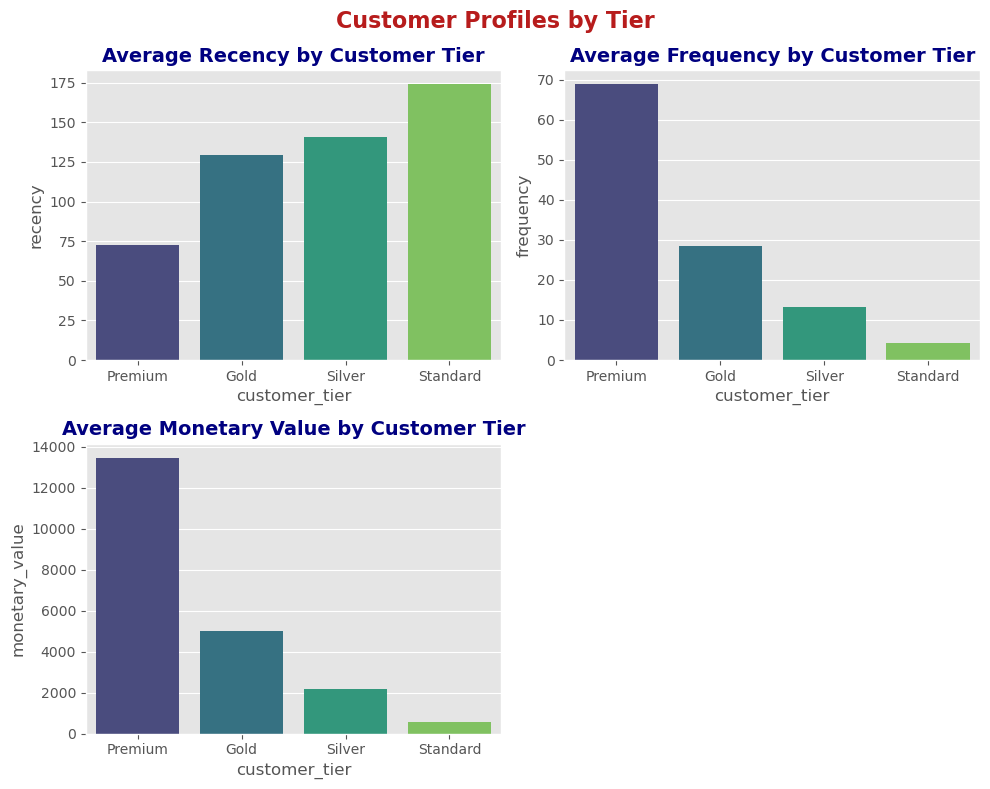

In [21]:
# Plot the customer profiles

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Plot recency
sns.barplot(x=customer_profiles.index, y='recency', data=customer_profiles, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Average Recency by Customer Tier', weight='bold', color='#000080', fontsize=14)

# Plot frequency
sns.barplot(x=customer_profiles.index, y='frequency', data=customer_profiles, palette='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Average Frequency by Customer Tier',weight='bold', color='#000080', fontsize=14)

# Plot monetary value
sns.barplot(x=customer_profiles.index, y='monetary_value', data=customer_profiles, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Average Monetary Value by Customer Tier', weight='bold', color='#000080', fontsize=14)

# Hide the empty subplot
axes[1, 1].axis('off')
# Add a title to the entire subplot
fig.suptitle('Customer Profiles by Tier', weight='bold', color='#B71C1C', fontsize=16)
# Adjust layout for better presentation
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
# save the datframe as csv file. 
customer_segments.to_csv('rfm_segments.csv', index_label=False)

##### **Strategy Recommendations:**

**Premium Customers:**

- Offer exclusive deals, early access to new products.
- Provide premium customer support.
- Encourage loyalty through personalized offers.

**Gold Customers:**

- Provide loyalty programs.
- Recommend complementary products.
- Offer occasional exclusive promotions.

**Silver Customers:**

- Implement targeted marketing campaigns.
- Offer discounts on specific product categories.
- Encourage repeat purchases.

**Standard Customers:**

- Focus on attracting and converting new customers.
- Provide general promotions and discounts.
- Implement strategies to increase customer retention.

________________________________________________

_____________________________________________________________

#### **b. Customer segmentation using K-Means & Understand the profiles**

Performing customer segmentation using K-Means clustering involves grouping customers into distinct segments based on their similarities

**Data Preperation**

In [16]:
# create discount_amount feature 
sales_df['discount_amount'] = sales_df['avg_price'] * sales_df['quantity'] * (sales_df['discount_pct'])

In [17]:
# date time 
sales_df['transaction_date'] = pd.to_datetime(sales_df['transaction_date'])

In [18]:
sales_df.head()

,customer_id,transaction_id,transaction_date,product_sku,product_description,product_category,quantity,avg_price,delivery_charges,coupon_status,...,gender,location,tenure_months,gst,coupon_code,discount_pct,invoice_value,first_purchase_date,customer_type,discount_amount
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,...,M,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New,15.3710
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.7100,6.5000,Used,...,M,Chicago,12,0.1000,ELEC10,0.1000,158.6729,2019-01-01,New,15.3710
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.0500,6.5000,Used,...,M,Chicago,12,0.1000,OFF10,0.1000,8.5295,2019-01-01,New,0.2050
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.5300,6.5000,Not Used,...,M,Chicago,12,0.1800,SALE10,0.1000,99.5843,2019-01-01,New,8.7650
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.5000,6.5000,Used,...,M,Chicago,12,0.1800,AIO10,0.1000,24.0230,2019-01-01,New,1.6500


**Customer level aggregation**

In [19]:
# customom function to calculate mode 
def calculate_mode(col):
    unique_elements, counts = np.unique(col, return_counts=True)
    max_count_index = np.argmax(counts)
    return unique_elements[max_count_index]

In [20]:
# lambda function to calculate coupen usage rate 
coupen_usage = lambda x: (x=='Used').mean()

In [21]:
customer_data = sales_df.groupby('customer_id').agg(
    revenue = ('invoice_value', 'sum'),
    total_orders = ('transaction_id', 'nunique'),
    favourite_category = ('product_category', calculate_mode),
    discount_recieved = ('discount_amount', 'mean'),
    avg_basket_size = ('quantity', 'mean'),
    coupen_usage_rate = ('coupon_status', lambda x: coupen_usage(x)),
    tenure_months = ('tenure_months', 'max'),
    gender = ('gender', 'first'),
    location = ('location', 'first'), 
).reset_index()

In [24]:
customer_data.head()

,customer_id,revenue,total_orders,favourite_category,discount_recieved,avg_basket_size,coupen_usage_rate,tenure_months,gender,location
0,12346,174.9817,1,Apparel,4.6485,1.5000,1.0000,31,F,New York
1,12347,12090.2958,31,Nest-USA,64.6979,5.7000,0.3333,20,M,New York
2,12348,1501.9262,8,Office,13.0269,9.0870,0.4783,39,M,California
3,12350,1183.7139,11,Apparel,24.0012,1.2353,0.3529,25,M,California
4,12356,1753.4509,13,Apparel,12.0206,1.5556,0.3056,31,F,Chicago


In [25]:
# calculate discount per order
customer_data['avg_discount_per_order'] = customer_data['discount_recieved'] / customer_data['total_orders']

In [26]:
# average order value 
customer_data['avg_order_value'] = customer_data['revenue'] / customer_data['total_orders']

In [27]:
# purchase frequency 
total_customers = len(customer_data)
customer_data['purchase_frequency'] = customer_data['total_orders'] / total_customers

In [28]:
customer_data.head()

,customer_id,revenue,total_orders,favourite_category,discount_recieved,avg_basket_size,coupen_usage_rate,tenure_months,gender,location,avg_discount_per_order,avg_order_value,purchase_frequency
0,12346,174.9817,1,Apparel,4.6485,1.5000,1.0000,31,F,New York,4.6485,174.9817,0.0007
1,12347,12090.2958,31,Nest-USA,64.6979,5.7000,0.3333,20,M,New York,2.0870,390.0095,0.0211
2,12348,1501.9262,8,Office,13.0269,9.0870,0.4783,39,M,California,1.6284,187.7408,0.0054
3,12350,1183.7139,11,Apparel,24.0012,1.2353,0.3529,25,M,California,2.1819,107.6104,0.0075
4,12356,1753.4509,13,Apparel,12.0206,1.5556,0.3056,31,F,Chicago,0.9247,134.8808,0.0089


In [29]:
# categorical data 
nominal_features = ['favourite_category', 'gender', 'location']

In [30]:
cust_data = customer_data.copy()
cust_data.drop('customer_id', axis=1, inplace=True)

In [31]:
# numerical columns 
numerical_features = cust_data.drop(nominal_features, axis=1).columns 

**Categorical Feature**

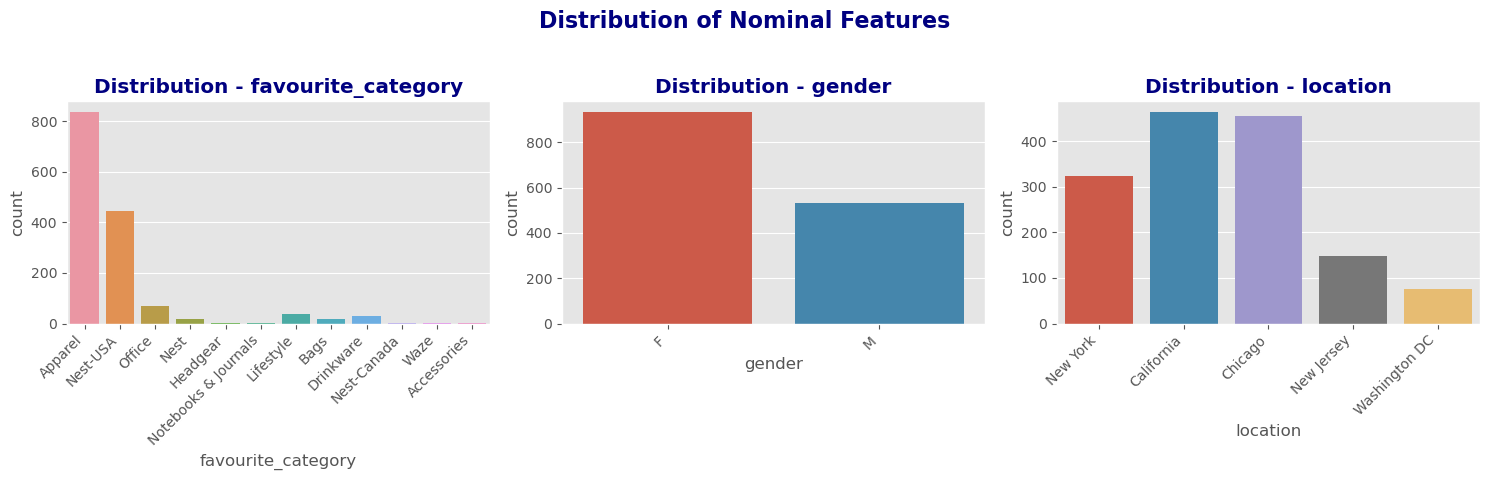

In [33]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(nominal_features), figsize=(15, 5))
fig.suptitle('Distribution of Nominal Features', weight='bold', color='#000080', fontsize=16)

# Plot the distribution for each nominal feature
for i, feature in enumerate(nominal_features):
    sns.countplot(x=feature, data=cust_data, ax=axes[i])
    axes[i].set_title(f'Distribution - {feature}', weight='bold', color='#000080')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to avoid title overlap
plt.show()

**Feature Selection**

Select relevent value based features for customer segmentation 

In [35]:
# select features for clustering 
f_sel = ['revenue', 'total_orders', 'avg_basket_size', 'avg_order_value']

In [36]:
# data with selected features 
df_fs = cust_data[f_sel]

In [37]:
# check for outliers 
df_fs.describe(percentiles=[0, 0.5, 0.75, 0.9, 0.95, 0.98, 0.99]).T

,count,mean,std,min,0%,50%,75%,90%,95%,98%,99%,max
revenue,1468.0000,3211.5201,5152.1526,6.9900,6.9900,1787.3979,3932.6869,7352.7329,10315.8676,16056.2543,20721.3749,78753.8942
total_orders,1468.0000,18.1410,24.9764,1.0000,1.0000,11.0000,23.0000,39.0000,55.0000,76.6600,104.6600,328.0000
avg_basket_size,1468.0000,4.4640,6.8329,1.0000,1.0000,2.4000,4.9400,9.2217,13.7933,22.6840,33.7437,103.0000
avg_order_value,1468.0000,171.1302,160.4340,6.9900,6.9900,153.8713,194.4310,260.6314,319.2450,434.6594,614.6694,4506.6094


**Outlier Treatment**

In [98]:
# funtion to clip outliers 
def clip_outliers(df, columns, upper_lim):
    """
    Clip outliers in specified columns of a DataFrame.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing numerical columns.
    - columns (list): List of column names to clip outliers.
    - upper_lim (float): Upper limit percentile value for clipping outliers.

    Returns:
    - pd.DataFrame: A new DataFrame with outliers clipped in specified columns.
    """
    df_clipped = df.copy()
    for col in columns:
        clip_val = np.percentile(df_clipped[col], upper_lim )
        df_clipped[col] = np.clip(df_clipped[col], None, clip_val)
    return df_clipped

In [39]:
# select columns to clip
outlier_cols = ['revenue', 'total_orders', 'avg_basket_size', 'avg_order_value']

In [40]:
# clip the selected features  to 99th percentile to remove extreme outliers 
df_clean =  clip_outliers(df_fs, outlier_cols, 99)

**Feature scaling**

In [41]:

# initiate robust scalar instance 
scaler = RobustScaler()
# scale the data 
cust_data_scaled = scaler.fit_transform(df_clean)

**Determine k value**

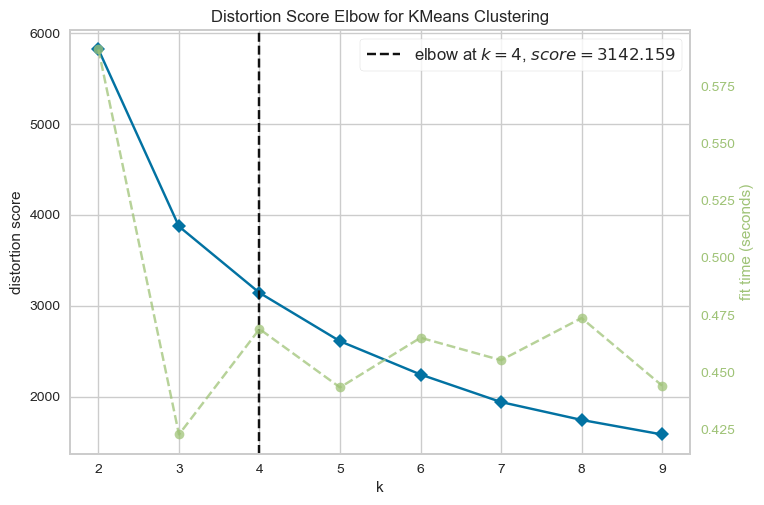

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
from yellowbrick.cluster import KElbowVisualizer

# Using Elbow Method to find the optimal number of clusters (K)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(cust_data_scaled)
visualizer.show()

**K-Means clustering**

In [43]:
# Fit K-means model with 4 clusters 
kmeans_model = KMeans(n_clusters=4, random_state=42)
customer_data['cluster'] = kmeans_model.fit_predict(cust_data_scaled)

In [46]:
kpi_data = customer_data[numerical_features]
kpi_data['cluster'] = customer_data['cluster']

===========================
### **Customer Profiling**
============================

In [47]:
# Group customer data by the 'cluster' column and calculate the mean for each cluster
cluster_profiles = kpi_data.groupby('cluster').mean()
# Print the resulting cluster profiles
cluster_profiles

,revenue,total_orders,discount_recieved,avg_basket_size,coupen_usage_rate,tenure_months,avg_discount_per_order,avg_order_value,purchase_frequency
cluster,,,,,,,,,
0,936.1544,7.6413,14.0750,2.0202,0.3399,26.2956,3.0971,112.1986,0.0052
1,14400.7005,75.8739,18.0634,4.5638,0.3363,26.4370,0.3028,191.7913,0.0517
2,3802.9216,9.6912,36.1259,26.9778,0.3499,26.1324,11.2673,437.8515,0.0066
3,3578.3046,19.8921,19.1738,4.7389,0.3376,25.3219,2.3350,206.1980,0.0136


**To visualize the distribution of clusters, you can create a count plot or a pie chart to show the proportion of data points in each cluster. Here's an example using a count plot**

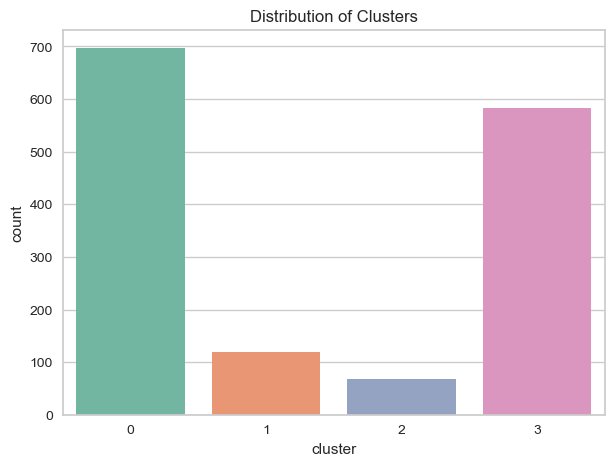

In [73]:
plt.figure(figsize=(7, 5))
sns.countplot(x='cluster', data=customer_data, palette='Set2')
plt.title('Distribution of Clusters')
plt.show()

**Visual representation of customer profiles segmented by clusters using a bar plot for each feature. The resulting visualization provides a concise overview of how each cluster differs in terms of mean values for various customer features.**

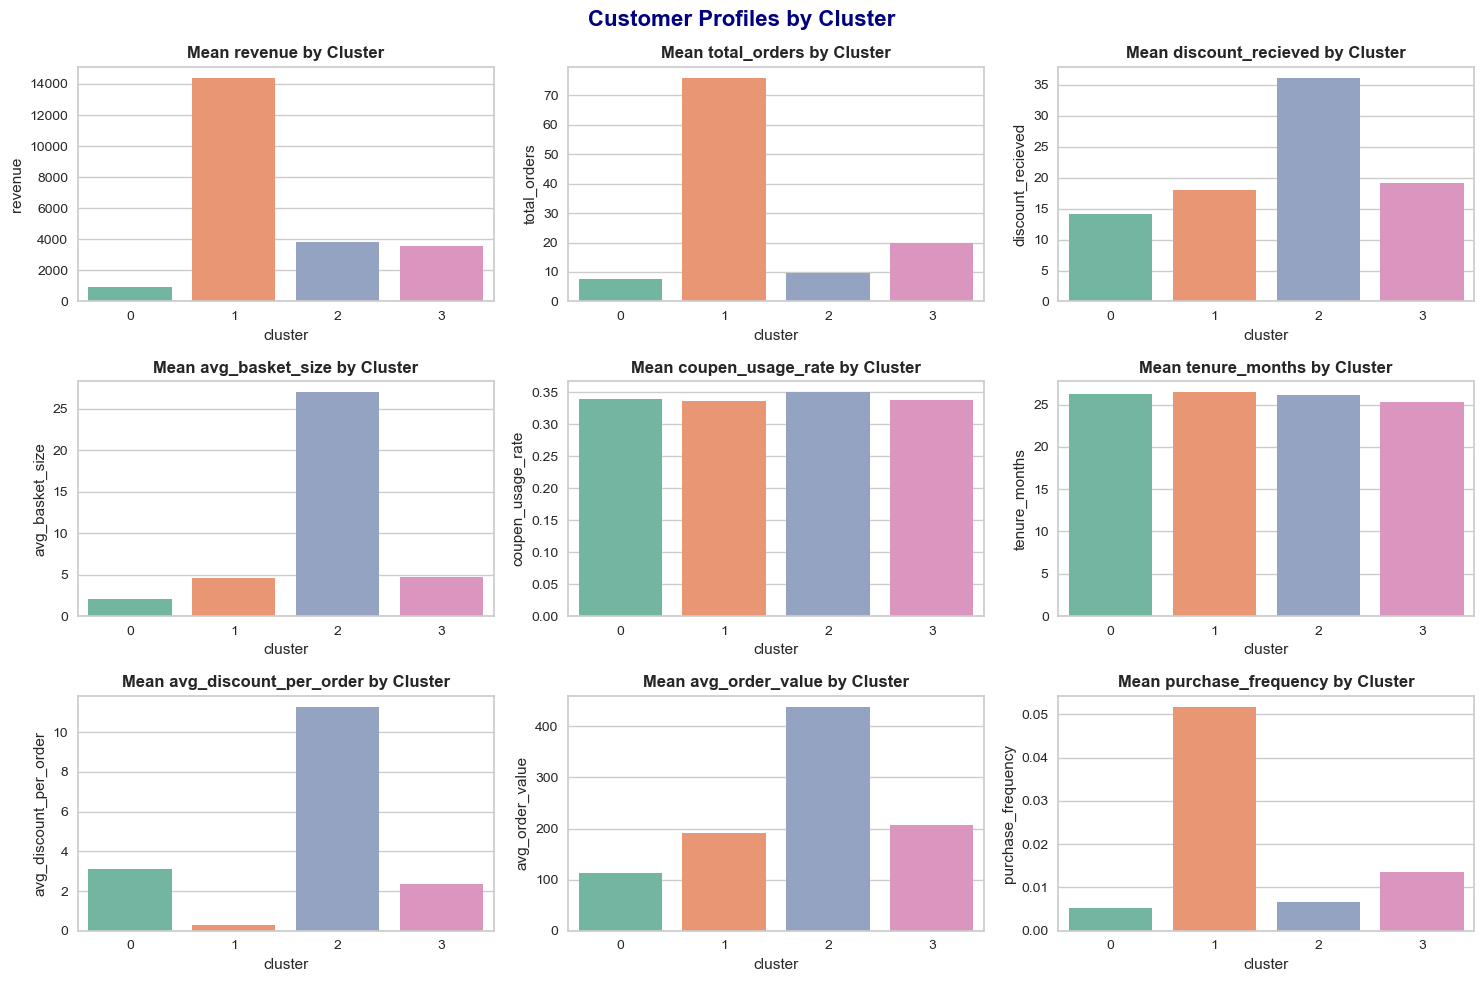

In [95]:
# Visualize the clusters
plt.figure(figsize=(15, 10))
plt.suptitle('Customer Profiles by Cluster', fontsize=16, weight='bold',color='#000080' )

# Create a bar plot for each feature
for i, column in enumerate(cluster_profiles.columns, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x=cluster_profiles.index,palette='Set2',  y=cluster_profiles[column])
    plt.title(f'Mean {column} by Cluster', weight='bold' )

plt.tight_layout()
plt.show()

Cluster profile based on Revenue and Tenure months.

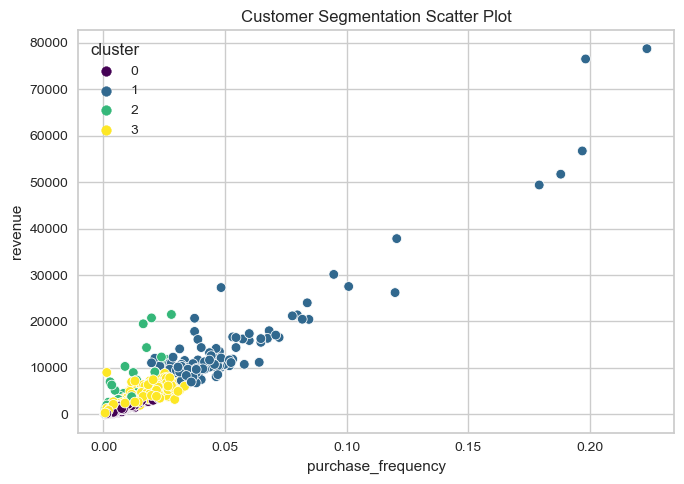

In [50]:
# Scatter plot for two features (e.g., 'revenue' and 'purchase_frequency')
plt.figure(figsize=(7, 5))
sns.scatterplot(x='purchase_frequency', y='revenue', hue='cluster', data=customer_data, palette='Set2')
plt.title('Customer Segmentation Scatter Plot')
plt.tight_layout()
plt.show()

In [55]:
# performance indicators 
kpi_features = ['revenue', 'total_orders', 'discount_recieved', 'avg_basket_size', 
                'coupen_usage_rate', 'tenure_months', 'avg_discount_per_order', 
                'avg_order_value', 'purchase_frequency' ]

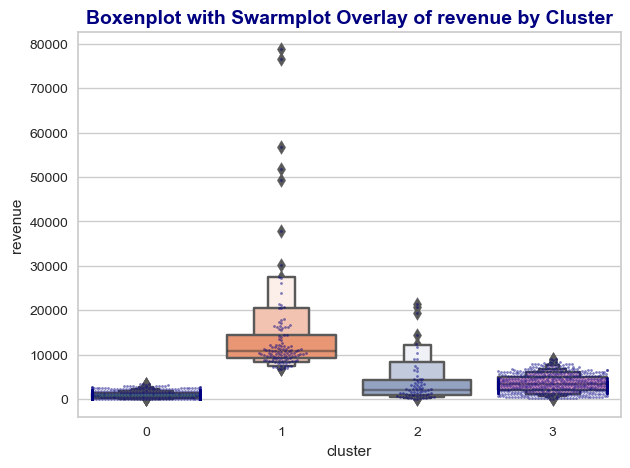

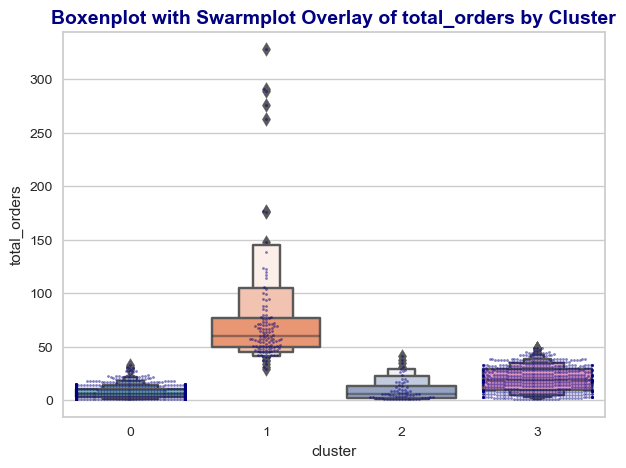

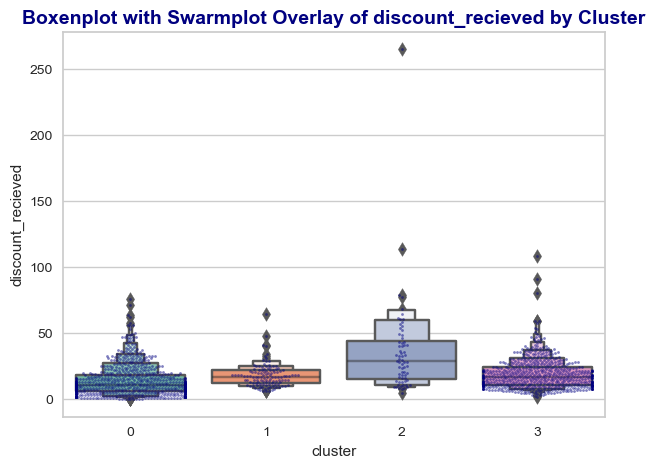

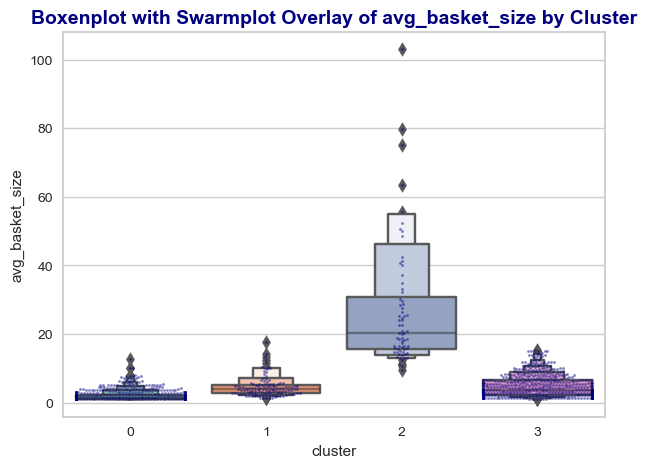

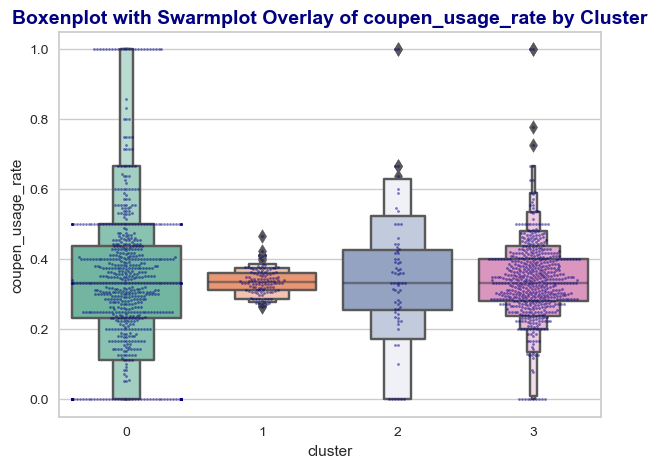

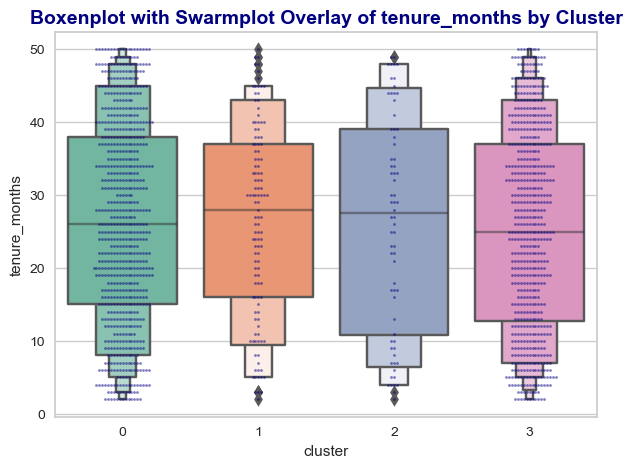

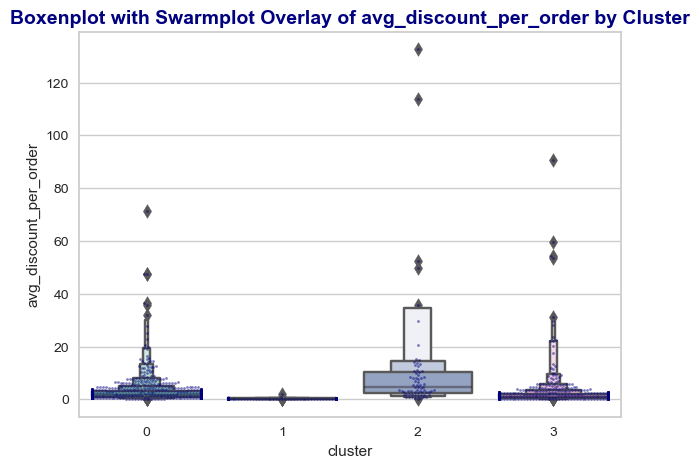

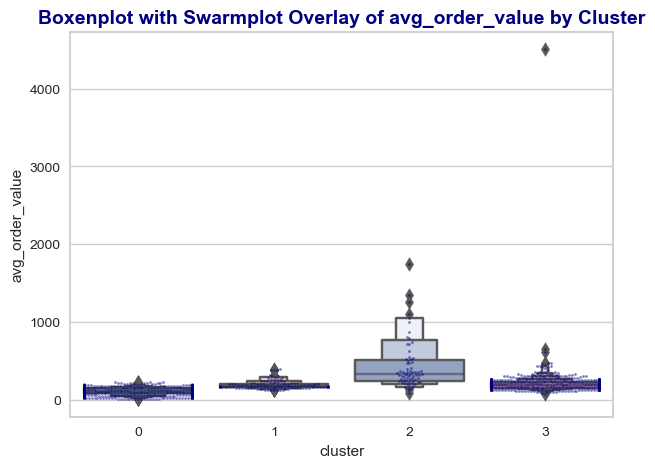

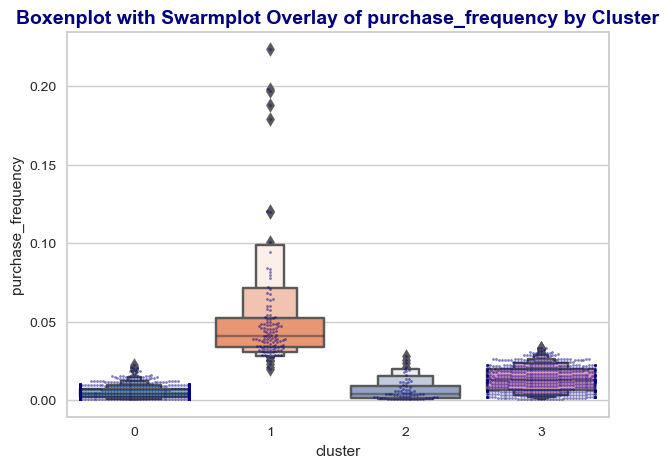

In [74]:
for feature in kpi_features:

    # Create a boxenplot with swarmplot overlay
    plt.figure(figsize=(7, 5))
    sns.boxenplot(x='cluster', y=feature, data=customer_data, palette='Set2')
    sns.swarmplot(x='cluster', y=feature, data=customer_data, color='#000080', size=2, alpha=0.5)  # Overlay swarmplot
    plt.title(f"Boxenplot with Swarmplot Overlay of {feature} by Cluster", weight='bold', color='#000080', fontsize=14 )
    plt.show()

**Clusters By Location**

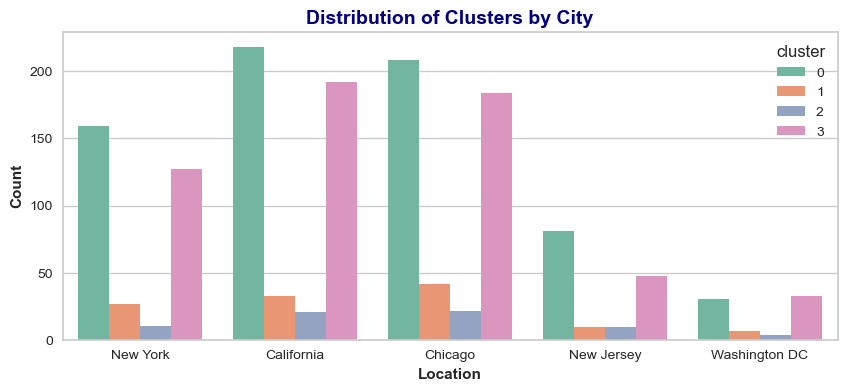

In [97]:
# count plot of location by cluster
plt.figure(figsize=(10, 4))
sns.countplot(x='location', data=customer_data,  hue='cluster', palette='Set2')
plt.title('Distribution of Clusters by City', weight='bold', color='#000080', fontsize=14)
plt.xlabel('Location', weight='bold')
plt.ylabel('Count', weight='bold')
plt.show()

**Cluster by gender**

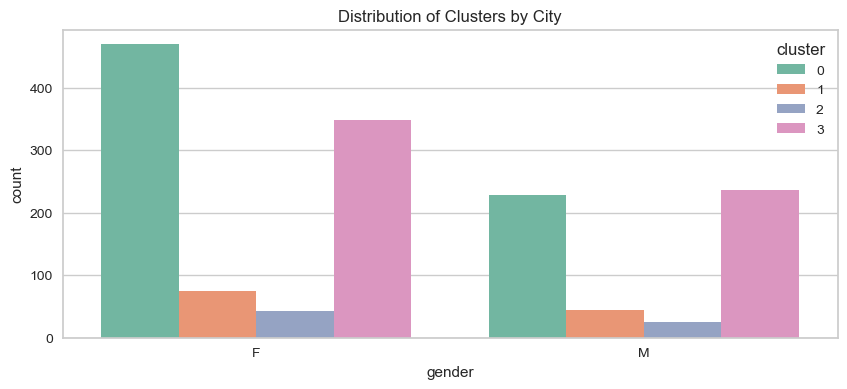

In [78]:
plt.figure(figsize=(10, 4))
sns.countplot(x='gender', data=customer_data,  hue='cluster', palette='Set2')
plt.title('Distribution of Clusters by City')
plt.show()

______________________________

### **Cluster Profiles**
============================
In addition to calculating the mean of key features, we used boxenplot with swarmplot overlay to visually examine cluster behavior. This combination of statistical analysis and visual representation provides a comprehensive understanding of the customer segments. below are our observations 
##### **Cluster 0**:
- **Revenue**: Low
- **Total Orders**: Low
- **Discount Received**: Moderate
- **Average Basket Size**: Low
- **Coupon Usage Rate**: Low
- **Tenure Months**: Moderate
- **Average Discount Per Order**: Moderate
- **Average Order Value**: Low
- **Purchase Frequency**: Low

**Interpretation**: Customers in this cluster seem to be less engaged, making fewer purchases with lower overall revenue. They are moderately tenured and tend to use coupons and receive discounts at a moderate rate.

##### **Cluster 1**:
- **Revenue**: High
- **Total Orders**: High
- **Discount Received**: Moderate
- **Average Basket Size**: High
- **Coupon Usage Rate**: Moderate
- **Tenure Months**: High
- **Average Discount Per Order**: Low
- **Average Order Value**: High
- **Purchase Frequency**: High

**Interpretation**: This cluster represents high-value customers. They have a high purchase frequency, make larger orders, and contribute significantly to the overall revenue. They show lower average discount per order and a higher average order value.

##### **Cluster 2**:
- **Revenue**: Moderate
- **Total Orders**: Low
- **Discount Received**: High
- **Average Basket Size**: Very High
- **Coupon Usage Rate**: High
- **Tenure Months**: Moderate
- **Average Discount Per Order**: Very High
- **Average Order Value**: Very High
- **Purchase Frequency**: Low

**Interpretation**: Customers in this cluster have a moderate overall revenue but make very high-value purchases. They receive a high level of discounts, use coupons frequently, and have a very high average basket size.

##### **Cluster 3**:
- **Revenue**: Moderate
- **Total Orders**: Moderate
- **Discount Received**: Moderate
- **Average Basket Size**: Moderate
- **Coupon Usage Rate**: Moderate
- **Tenure Months**: Moderate
- **Average Discount Per Order**: Moderate
- **Average Order Value**: Moderate
- **Purchase Frequency**: Moderate

**Interpretation**: This cluster represents a balanced group of customers with moderate values across various metrics. They are neither extremely high nor low in any specific aspect.


____________________

### **Strategies for Each Cluster**
====================================

##### **Cluster 0: Less Engaged Customers**
- **Strategy**: Focus on increasing customer engagement and encouraging repeat purchases.
- **Tactics**:
  - Implement targeted marketing campaigns to re-engage customers.
  - Offer personalized discounts or promotions to increase purchase frequency.
  - Provide incentives for trying new products or categories.

##### **Cluster 1: High-Value Customers**
- **Strategy**: Retain and maximize value from these valuable customers.
- **Tactics**:
  - Provide exclusive offers or loyalty programs to maintain their loyalty.
  - Implement a personalized communication strategy based on their preferences.
  - Introduce premium products or services to encourage larger orders.

##### **Cluster 2: High-Value Shoppers with Discounts**
- **Strategy**: Optimize discounts and promotions to drive revenue.
- **Tactics**:
  - Continue offering discounts on high-value items to maintain their interest.
  - Create targeted campaigns highlighting exclusive deals for this segment.
  - Analyze discount effectiveness to ensure profitability.

##### **Cluster 3: Balanced Customers**
- **Strategy**: Maintain a balanced approach to retain and gradually increase engagement.
- **Tactics**:
  - Implement personalized communication without overwhelming customers.
  - Offer moderate discounts or promotions based on their historical behavior.
  - Monitor customer feedback and adjust strategies accordingly.


_____________________________________________________